# Hot Plasma Composition Analyzer
author: Louis Richard\
HPCA summary plot

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from pyrfu import mms
from pyrfu.plot import plot_line, plot_spectr, make_labels

Load IGRF coefficients ...


## Define spacecraft index, time interval and species

In [2]:
ic = 1
mms.db_init("/Volumes/mms")
tint = ["2017-07-23T16:54:00.000", "2017-07-23T17:00:00.000"]
species = {"hplus": "$H^+$", "heplus": "$He^+$", "heplusplus": "$He^{2+}$", "oplus": "$O^+$"}

## Load data

### Load HPCA moments

In [3]:
n_hpca = [mms.get_data(f"n{s}_hpca_srvy_l2", tint, ic) for s in species.keys()]
v_xyz_hpca = [mms.get_data(f"v{s}_dbcs_hpca_srvy_l2", tint, ic) for s in species.keys()]

09-Dec-21 11:18:14: Loading mms1_hpca_hplus_number_density...
09-Dec-21 11:18:15: Loading mms1_hpca_heplus_number_density...
09-Dec-21 11:18:17: Loading mms1_hpca_heplusplus_number_density...
09-Dec-21 11:18:18: Loading mms1_hpca_oplus_number_density...
09-Dec-21 11:18:20: Loading mms1_hpca_hplus_ion_bulk_velocity...
09-Dec-21 11:18:21: Loading mms1_hpca_heplus_ion_bulk_velocity...
09-Dec-21 11:18:23: Loading mms1_hpca_heplusplus_ion_bulk_velocity...
09-Dec-21 11:18:25: Loading mms1_hpca_oplus_ion_bulk_velocity...


### Load HPCA ion

In [4]:
flux_hpca = [mms.get_data(f"dpf{s}_hpca_srvy_l2", tint, ic) for s in species.keys()]

09-Dec-21 11:18:28: Loading mms1_hpca_hplus_flux...
09-Dec-21 11:18:30: Loading mms1_hpca_heplus_flux...
09-Dec-21 11:18:33: Loading mms1_hpca_heplusplus_flux...
09-Dec-21 11:18:36: Loading mms1_hpca_oplus_flux...


### Load magnetic field

In [5]:
b_xyz = mms.get_data("b_gse_fgm_srvy_l2", tint, ic)

09-Dec-21 11:18:39: Loading mms1_fgm_b_gse_srvy_l2...


## Compute ion fluxes

In [6]:
def calc_hpca_flux(flux):
    flux.data[flux.data <= 0] = np.nan
    coords = [flux.time.data, flux.ccomp.data]
    dims = ["time", "energy"]

    out = xr.DataArray(np.nanmean(flux.data, axis=1), coords=coords, dims=dims, attrs=flux.attrs)
    return out

flux_hpca = [calc_hpca_flux(flux) for flux in flux_hpca]

09-Dec-21 11:18:41: <ipython-input-6-ac09cfa16d7c>:6: RuntimeWarning: Mean of empty slice
  out = xr.DataArray(np.nanmean(flux.data, axis=1), coords=coords, dims=dims, attrs=flux.attrs)



## Plot

In [7]:
legend_options = dict(ncol=max([3, len(species.keys())]), frameon=True, loc="upper right")

<IPython.core.display.Javascript object>


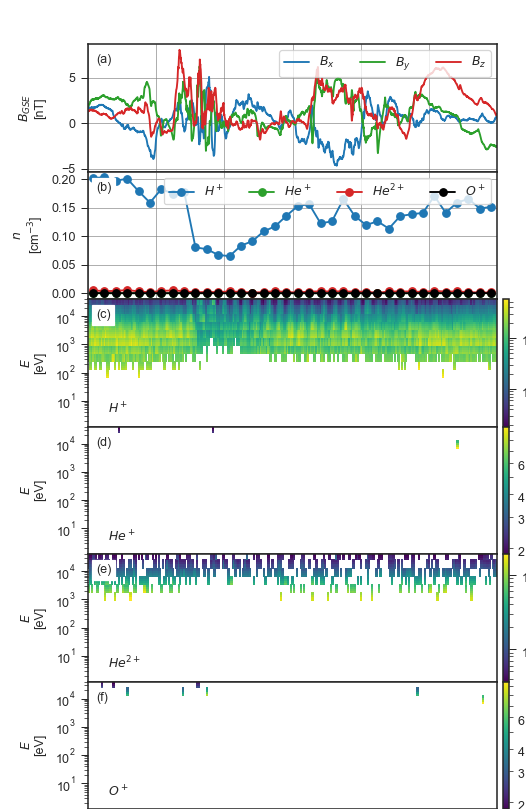

array([<AxesSubplot:ylabel='$B_{GSE}$\n[nT]'>,
       <AxesSubplot:ylabel='$n$\n[cm$^{-3}$]'>,
       <AxesSubplot:ylabel='$E$\n[eV]'>, <AxesSubplot:ylabel='$E$\n[eV]'>,
       <AxesSubplot:ylabel='$E$\n[eV]'>, <AxesSubplot:ylabel='$E$\n[eV]'>],
      dtype=object)

In [9]:
%matplotlib notebook
f, axs = plt.subplots(6, sharex="all", figsize=(6.5, 10))
f.subplots_adjust(bottom=.1, top=.95, left=.15, right=.85, hspace=0)

plot_line(axs[0], b_xyz)
axs[0].set_ylabel("$B_{GSE}$" + "\n" + "[nT]")
axs[0].legend(["$B_{x}$", "$B_{y}$", "$B_{z}$"], **legend_options)

labels = []
for n, s in zip(n_hpca, species.keys()):
    plot_line(axs[1], n, linestyle="-", marker="o")
    labels.append(species[s])
    
axs[1].set_ylabel("$n$" + "\n" + "[cm$^{-3}$]")
axs[1].legend(labels, **legend_options)

caxs = [None] * len(species)
for s, ax, cax, flux in zip(species.keys(), axs[2:], caxs, flux_hpca):
    ax, cax = plot_spectr(ax, flux, yscale="log", cscale="log", cmap="viridis")
    ax.set_ylabel("$E$" + "\n" + "[eV]")
    cax.set_ylabel("flux" + "\n" + "[1/cc s sr eV]")
    ax.text(0.05, 0.1, species[s], transform=ax.transAxes)
    
f.align_ylabels(axs)
make_labels(axs, [0.02, 0.85])
